
* With the current setup
    * Get the yearly mean for our rough estimate

    * Get the weighted areas, to get energy per grid box




* Can we satisfy the instantaneus demand?
    * Get the instantaneus max demand in a year (Najme)

* Where to put the solar panels?
   * Which are the areas of higher contribution (Selma's cool algorithm)
       * Use top 30 boxes for the local maxima ie, 30 boxes with highest pvpot (mean pvpot or sum pvpot)
   * What makes a place a good place to put solar panels? (Najme)
       *  Radiation, temperature and wind are already accounted in pvpot
       *  ?
       *  Are mountains a good place?
       *  Populated areas?
       *  Beach front
       *  Natural reserves (parks)
       *  Ocean or sea ? can we put them in the mediterranian

* Problem for the future:
    * Max pvpot is at mid day, max consumption is in the evenening
       * What is the maximum difference?
       * How much energy should be stored or commerced(import export)?

### NEXT STEPS (Meeting 08/12/24)
- plot energy per cell for entire year
- Sums for the months
- Sum for entire year

- Where to put the solar panels (see previous comment)

In [1]:
%load_ext autoreload
%autoreload
import tools as tools
import core as core

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# Open dataset and filter for europe
# range=> [) is open on the right side so +1 to remember
ds = tools.open_dataset(months=range(1,12+1))

mask = xr.open_mfdataset("/home/leonardoq88/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5_landseamask.nc", engine="h5netcdf", chunks={"valid_time": 1e5})

ds_eu = tools.filter_europe_box(ds)

# Filter for Iran
# ds_eu = ds.sel(latitude=slice(40, 24)).sel(longitude=slice(40, 62))

In [4]:
mask_eu = tools.filter_europe_box(mask)

In [5]:
ds_eu

<xarray.Dataset> Size: 5GB
Dimensions:     (valid_time: 8784, latitude: 141, longitude: 161)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 70kB 2000-01-01 ... 2000-12-31T23...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 141kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

Lets do a rough estimate with the area of europe

In [6]:
# Lets do a rough estimate calculating the overall mean
pvpot_pre = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).mean(dim=("valid_time","latitude","longitude"))

In [7]:
# Do the proper computation
pvpot = tools.dask_compute(pvpot_pre, workers=5, threads=2)

<Client: 'tcp://127.0.0.1:38073' processes=5 threads=10, memory=753.83 GiB>
Execution time: 28.42507 seconds


In [8]:
ds_eu

<xarray.Dataset> Size: 5GB
Dimensions:     (valid_time: 8784, latitude: 141, longitude: 161)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 70kB 2000-01-01 ... 2000-12-31T23...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 141kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 798MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
tools.print_pvpot_stats(pvpot)

Calculated pvpot:
    Shape: (12,)
    Months: 12
    Min: 0.03547180816531181
    Mean: 0.13677673041820526
    Max: 0.24583707749843597
    Std: 0.07454156875610352
    


In [10]:
print(f"Each square meter can produce a max of {pvpot.values*237} Watts in January")

Each square meter can produce a max of [11.157536 18.453064 31.556204 44.305676 55.20349  58.263386 52.804558
 45.378643 32.58448  19.455956 11.423204  8.406818] Watts in January


In [11]:
import pint
from pint import UnitRegistry
ureg = UnitRegistry()

# Doing a naive calculation of europe

#AREA:
area_europe = 10.53e6 * (ureg.kilometer * ureg.kilometer)
# '#' compact '~' short 'P' Pretty
print(f"Area Europe: {area_europe:#P}")

# Panel rate for panels ---
panel_rated_ouput = 237 * ureg.watt / (ureg.meter * ureg.meter)
print(f"Panel Rated Output: {panel_rated_ouput:#~P}")

europe_max_solar_energy = np.mean(pvpot.values) * panel_rated_ouput * area_europe
print(f"Max solar energy production europe: {europe_max_solar_energy:#~P.2f}")


europe_max_solar_energy_month = europe_max_solar_energy * (720 * ureg.hour)
print(f"Max solar energy production europe month Wh: {europe_max_solar_energy_month:#~P.2f}")
print(f"Max solar energy production europe month J: {europe_max_solar_energy_month.to('joule'):#P.2f}")


Area Europe: 10.53 megameter²
Panel Rated Output: 237.0 W/m²
Max solar energy production europe: 341.34 TW
Max solar energy production europe month Wh: 245.77 h·PW
Max solar energy production europe month J: 884.76 exajoule


In [12]:
# https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_e__custom_13932565/default/table?lang=en
europe_electricity_consumption = 2824313.722 * 10e9 * ureg.Wh
print(f"{europe_electricity_consumption.to('gigawatthour'):_}")
print(f"{europe_electricity_consumption.to('gigawatthour'):#~P}")

28_243_137.220000003 gigawatt_hour
28.24313722 PWh


In [13]:
# Consumption 
europe_electricity_consumption / europe_max_solar_energy_month 

<Quantity(114918.912, 'watt_hour * meter ** 2 / watt / kilometer ** 2 / hour')>

In [14]:
# 84 PW H europe max January over 28 PW H europe year consumption
84.59/28.2

2.9996453900709223

## Better calculation with More precise area

In [15]:
pvpot_pre = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).mean(dim=("valid_time"))

In [16]:
pvpot = tools.dask_compute(pvpot_pre, workers=5, threads=2)

<Client: 'tcp://127.0.0.1:42575' processes=5 threads=10, memory=753.83 GiB>
Execution time: 27.29845 seconds


In [17]:
tools.print_pvpot_stats(pvpot)

Calculated pvpot:
    Shape: (12, 141, 161)
    Months: 12
    Min: 0.0
    Mean: 0.13677674531936646
    Max: 0.32627660036087036
    Std: 0.0850083976984024
    


In [18]:
pvpot[0]

<xarray.DataArray (latitude: 141, longitude: 161)> Size: 91kB
array([[0.00031222, 0.00031471, 0.00031644, ..., 0.00029615, 0.00029874,
        0.00029938],
       [0.00039874, 0.00040131, 0.00040305, ..., 0.00038027, 0.00038839,
        0.00037046],
       [0.00050565, 0.0005067 , 0.00050641, ..., 0.00046286, 0.0004429 ,
        0.00042279],
       ...,
       [0.12258013, 0.12240249, 0.12198541, ..., 0.12548393, 0.12480054,
        0.12452262],
       [0.12356924, 0.12347526, 0.1234018 , ..., 0.12480268, 0.12513228,
        0.12538747],
       [0.1241347 , 0.12420183, 0.12458853, ..., 0.12378363, 0.12454746,
        0.12511471]], dtype=float32)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude  (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    month      int64 8B 1

In [19]:
mask_pvpot = pvpot * mask_eu["lsm"][0]

In [20]:
mask_pvpot.load()

<xarray.DataArray (month: 12, latitude: 141, longitude: 161)> Size: 1MB
array([[[0.        , 0.        , 0.        , ..., 0.00017976,
         0.00016678, 0.00016234],
        [0.        , 0.        , 0.        , ..., 0.00030158,
         0.00025296, 0.0002301 ],
        [0.        , 0.        , 0.        , ..., 0.00043468,
         0.00040638, 0.00037877],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.01027691,
         0.00964685, 0.00953234],
        [0.        , 0.        , 0.        , ..., 0.01400645,
         0.0118316 , 0.01117807],
        [0.        , 0.        , 0.        , ..., 0.01655709,
         0.01596702, 0.0153904 ],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
  * month       (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    valid_time  datetime64[ns] 8B 2000-01-01
    expver      <U4 16B '0001'

Text(0.5, 0.98, 'MegaWatts Hour per month per m^2')

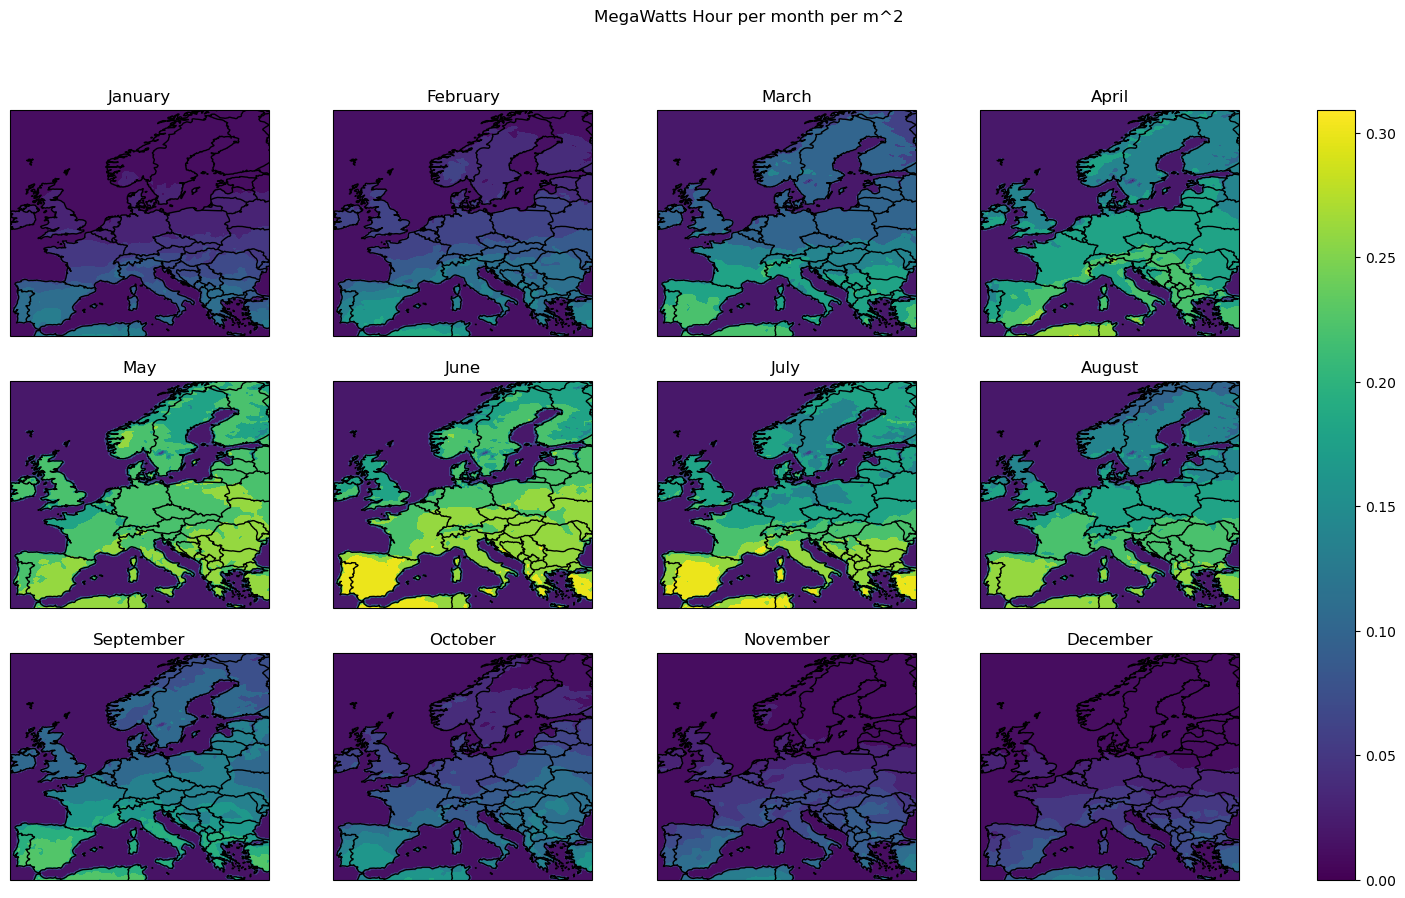

In [21]:
fg, ax = tools.plot_pvpot_per_month(mask_pvpot, 0, mask_pvpot.max())
fg.suptitle("MegaWatts Hour per month per m^2")

In [22]:
import math
def calculate_cell_area(lat1, lat2, lon1, lon2, radius=6371):
    # Convert degrees to radians
    lat1, lat2, lon1, lon2 = map(math.radians, [lat1, lat2, lon1, lon2])
    
    # Calculate the area
    area = radius**2 * abs(math.sin(lat2) - math.sin(lat1)) * abs(lon2 - lon1)
    return area

# Example: Calculate area of a cell
# lat1, lat2 = 3, 3.25  # Latitude bounds
# lon1, lon2 = 5, 5.25  # Longitude bounds
# area = calculate_cell_area(lat1, lat2, lon1, lon2)
# print(f"Area of the cell: {area:.2f} km²")

In [23]:
def grid_cell_area(ds, radius=6371):
    """
    Berechnet die Fläche jeder Gitterzelle basierend auf lat/lon.
    
    Parameters:
        ds (xarray.Dataset): Dataset mit lat/lon-Dimensionen.
        radius (float): Erdradius in Kilometern (Standard: 6371 km).
        
    Returns:
        xarray.DataArray: Flächenwerte für alle Zellen.
    """
    # Sekunden pro Stunde (falls später benötigt)
    sechour = 3600 

    # Extrahiere die Koordinaten für Latitude und Longitude
    lat = ds['latitude'].values
    lon = ds['longitude'].values

    # Berechnung der Bounds (Lat/Lon-Zellenränder)
    lat_bounds = np.concatenate(([lat[0] - (lat[1] - lat[0]) / 2], 
                                  lat[:-1] + np.diff(lat) / 2, 
                                  [lat[-1] + (lat[-1] - lat[-2]) / 2]))
    lon_bounds = np.concatenate(([lon[0] - (lon[1] - lon[0]) / 2], 
                                  lon[:-1] + np.diff(lon) / 2, 
                                  [lon[-1] + (lon[-1] - lon[-2]) / 2]))

    # Flächendifferenzen in Radians
    dlat = np.abs(np.diff(np.sin(np.radians(lat_bounds))))
    dlon = np.abs(np.diff(lon_bounds)) * np.pi / 180

    # Gitter für dlat und dlon erstellen
    dlat_grid, dlon_grid = np.meshgrid(dlat, dlon, indexing="ij")

    # Flächenberechnung für jede Gitterzelle
    cell_areas = radius**2 * dlat_grid * dlon_grid

    # Rückgabe als DataArray
    area_da = xr.DataArray(
        cell_areas,
        coords={"latitude": lat, "longitude": lon},
        dims=["latitude", "longitude"],
        name="cell_area"
    )
    return area_da


In [24]:
ds_eu['cell_area'] = grid_cell_area(ds_eu)
ds_eu['pv_pot'] = mask_pvpot

In [25]:
# Panel rate for panels ---
panel_rated_ouput_per_m2 = 237 # Watts 

ds_eu["energy_potential_per_m2"] = ds_eu["pv_pot"] * panel_rated_ouput_per_m2

ds_eu["energy_potential_per_cell"] = ds_eu["energy_potential_per_m2"] * ds_eu["cell_area"] * 1e6 # Since cell area is in km^2

In [26]:
ds_eu["cell_area"]

<xarray.DataArray 'cell_area' (latitude: 141, longitude: 161)> Size: 182kB
array([[264.30251932, 264.30251932, 264.30251932, ..., 264.30251932,
        264.30251932, 264.30251932],
       [267.46848672, 267.46848672, 267.46848672, ..., 267.46848672,
        267.46848672, 267.46848672],
       [270.62936191, 270.62936191, 270.62936191, ..., 270.62936191,
        270.62936191, 270.62936191],
       ...,
       [629.12312831, 629.12312831, 629.12312831, ..., 629.12312831,
        629.12312831, 629.12312831],
       [631.07517092, 631.07517092, 631.07517092, ..., 631.07517092,
        631.07517092, 631.07517092],
       [633.01519876, 633.01519876, 633.01519876, ..., 633.01519876,
        633.01519876, 633.01519876]])
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude  (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0

In [27]:
potential_month = (ds_eu["energy_potential_per_cell"] * 3600 * 24 * 30).sum(axis=(1,2))

In [28]:
potential_month/1e18

<xarray.DataArray 'energy_potential_per_cell' (month: 12)> Size: 96B
array([197.63894679, 305.71703454, 492.19631914, 651.04361718,
       809.7646485 , 855.81057081, 753.98026082, 693.15670175,
       505.43323209, 317.19233412, 191.67015337, 145.17661223])
Coordinates:
    number   int64 8B 0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [29]:
print(f"Max solar energy production europe month Wh: {europe_max_solar_energy_month:#~P.2f}")
print(f"Max solar energy production europe month J: {europe_max_solar_energy_month.to('joule'):#P.2f}")

Max solar energy production europe month Wh: 245.77 h·PW
Max solar energy production europe month J: 884.76 exajoule


In [30]:
pot = ds_eu["energy_potential_per_cell"][1].sum(axis=(0,1))
pot


<xarray.DataArray 'energy_potential_per_cell' ()> Size: 8B
array(1.17946387e+14)
Coordinates:
    number   int64 8B 0
    month    int64 8B 2

In [31]:
ds_eu["energy_potential_per_cell"]

<xarray.DataArray 'energy_potential_per_cell' (month: 12, latitude: 141,
                                               longitude: 161)> Size: 2MB
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.12599722e+07, 1.04470254e+07, 1.01690796e+07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.91171206e+07, 1.60349106e+07, 1.45862229e+07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.78798672e+07, 2.60647224e+07, 2.42939453e+07],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.43742789e+08, 6.04275717e+08, 5.97103014e+08],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.87869031e+08, 7.50005269e+08, 7.08577951e+08],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.06195769e+09, 1.02411149e+09, 9.87127254e+08],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude  (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

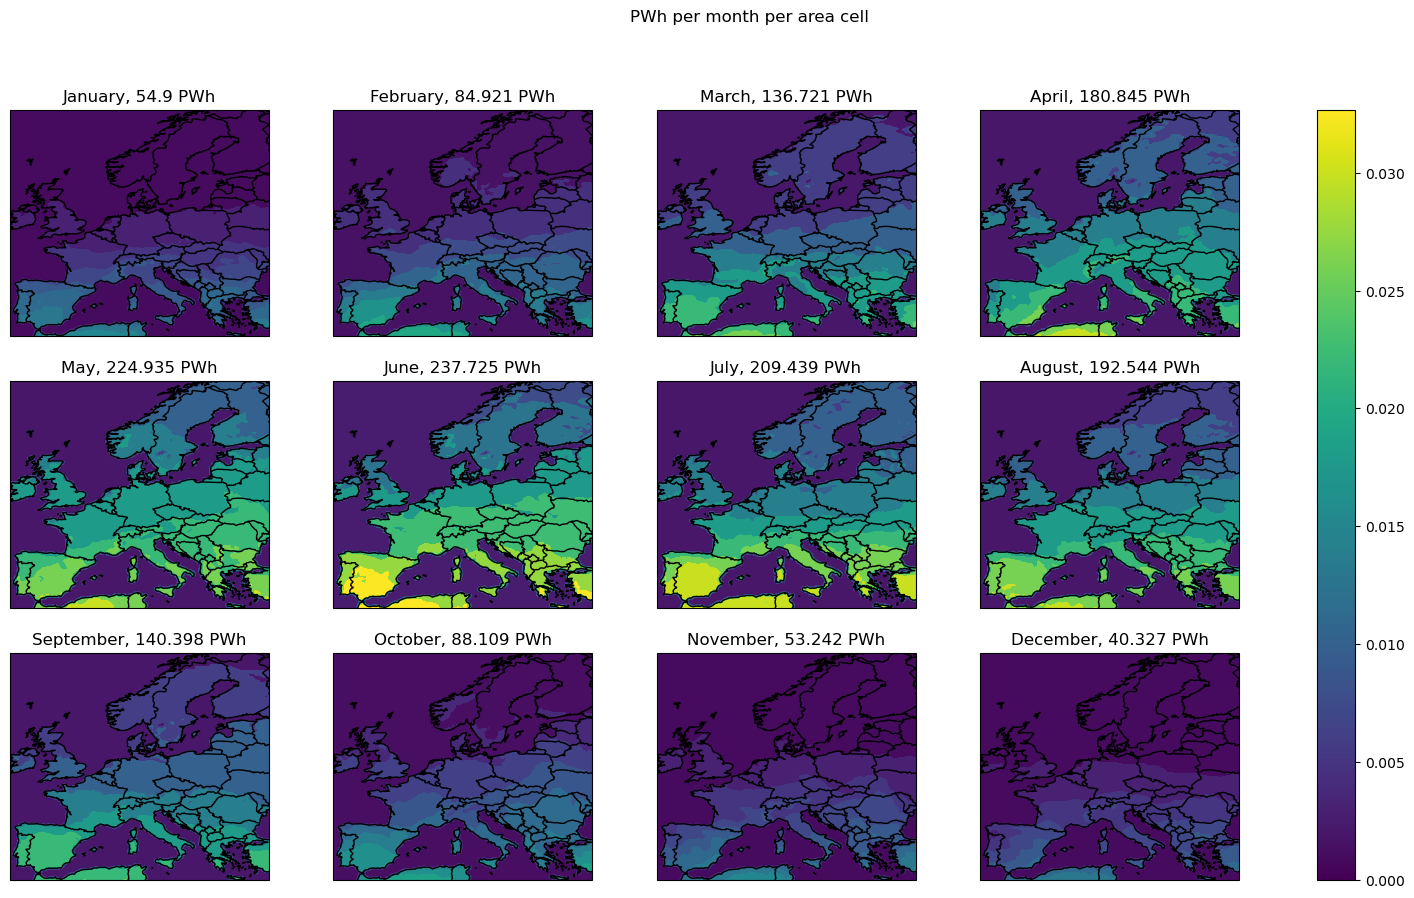

In [32]:
energy_month_per_cell = (ds_eu["energy_potential_per_cell"]*24*30)/1e15
fg, ax = tools.plot_pvpot_per_month(energy_month_per_cell, 0, energy_month_per_cell.max(), datatype = "total_energy")
fg.suptitle("PWh per month per area cell");

In [33]:
year_sum = ((ds_eu["energy_potential_per_cell"]*24*30).sum().values/1e15).round(3)
print(f"Sum for the entire year : , {year_sum:_}, PWh" )

Sum for the entire year : , 1_644.106, PWh


In [34]:
area_ratio = (europe_electricity_consumption.magnitude/1e15)/year_sum
print(f"Electricity consumption in 2022 was: {europe_electricity_consumption.magnitude/1e15} PWh")
print(f"Theoretically, {area_ratio*100:.2f} % of Europe's area could provide enough energy.")

Electricity consumption in 2022 was: 28.24313722 PWh
Theoretically, 1.72 % of Europe's area could provide enough energy.


In [35]:
total_area_square = ds_eu["cell_area"].sum()
print(f"Total area of the square: {total_area_square:_.2f} km\u00b2. {area_ratio*100:.2f} % of that: {total_area_square*area_ratio:_.2f} km\u00b2")

Total area of the square: 10_511_653.74 km². 1.72 % of that: 180_573.56 km²


## Further ideas
- see pvpot changing over the years or decades
- find areas that we could cover with pv panels (to answer the *where*)
- Thinking about the storage problem: maximum differences, power consumption and production curves over different time periods...

### Notes 10.12.2024
- max consumption in a month, max production in a month, so average "monthly buffer" (Naj)
- Sort grid cells top producing to bottom producing and then just sum until you reach what you need (Leo)
- Use ocean mask (Selma)

In [88]:
def get_cells_to_cover_consumption(potential_production, desired_production):
    production_cells = []
    energy_coverage = 0
    energy_flat = potential_production.values.flatten()
    mi = np.argsort(energy_flat)[::-1]

    last_printed_percent = 0.0
    for idx in mi:
        lat_idx, lon_idx = np.unravel_index(idx, potential_production.shape)
        energy = energy_flat[idx]
        energy_coverage += energy
        production_cells.append({
            "energy": energy,
            "latitude": ds_eu.latitude.values[lat_idx],
            "longitude": ds_eu.longitude.values[lon_idx],
        })
        if energy_coverage > desired_production:
            break
        else:
            new_coverage_percent = energy_coverage/desired_production
            if (new_coverage_percent - last_printed_percent) > 0.1:
                print(f"Current coverage {energy_coverage:.2e} or {energy_coverage*100/desired_production:.0f}% ")
                last_printed_percent = new_coverage_percent
    print(f"Last coverage {energy_coverage:.2e} or {energy_coverage*100/desired_production:.0f}% ")
    return production_cells


In [87]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Example: max_coordinates contains the max 10 coordinates and their pvpot values
# max_coordinates = [{'pvpot': value, 'latitude': lat, 'longitude': lon, 'month': month}, ...]

def plot_panel_locations(cells):
    # Set up the map
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add a base map (using Cartopy's Natural Earth features)
    ax.set_extent([-30, 40, 30, 75], crs=ccrs.PlateCarree())  # Limits for Europe
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.7)
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    
    # Extract coordinates and values from max_coordinates
    latitudes = [coord['latitude'] for coord in cells]
    longitudes = [coord['longitude'] for coord in cells]
    
    # Plot the coordinates as red points
    ax.scatter(longitudes, latitudes, color='red', marker='s', label='Solar Panels', transform=ccrs.PlateCarree())
    
    ax.gridlines(draw_labels=True, color='gray', linestyle='--', linewidth=0.5)
    # Optionally: Label the points with their pvpot values
    # for coord in max_coordinates:
    #     ax.text(coord['longitude'] + 0.5, coord['latitude'], f"{coord['energy']:.2f}", color='red', fontsize=10,
    #             transform=ccrs.PlateCarree())
    
    # Show the plot
    plt.title('Panel sugested Locations Europe')
    plt.legend(loc='upper left')
    plt.show()


Current coverage 2.91e+15 or 10% 
Current coverage 5.78e+15 or 20% 
Current coverage 8.61e+15 or 30% 
Current coverage 1.17e+16 or 41% 
Current coverage 1.47e+16 or 52% 
Current coverage 1.78e+16 or 63% 
Current coverage 2.08e+16 or 74% 
Current coverage 2.38e+16 or 84% 
Current coverage 2.68e+16 or 95% 
Last coverage 2.83e+16 or 100% 
Total selected cells 111


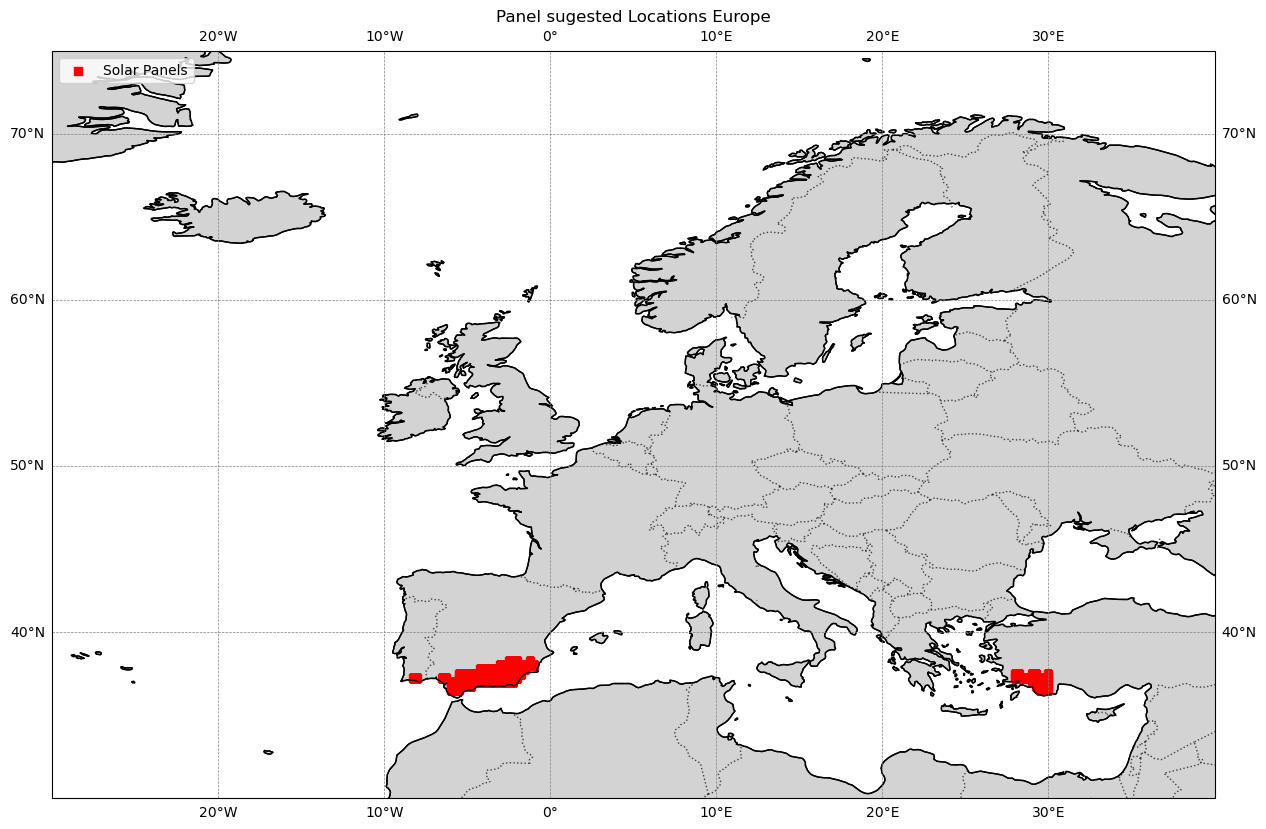

In [95]:
energy_year = ds_eu.energy_potential_per_cell.sum(dim="month") * 24 * 30
# Dont select cells in Algeria
energy_year.loc[(energy_year.latitude < 37), (energy_year.longitude <= 15) & (energy_year.longitude >= 0) ] = 0
energy_year.loc[(energy_year.latitude < 36), (energy_year.longitude < 0) & (energy_year.longitude > -10) ] = 0

cells = get_cells_to_cover_consumption(energy_year, europe_electricity_consumption.magnitude)
print(f"Total selected cells {len(cells)}")
plot_panel_locations(cells)

In [80]:
area_covered = 0
for c in cells:
    area_covered += ds_eu.cell_area.sel(latitude=c["latitude"], longitude=c["longitude"])
area_covered

<xarray.DataArray 'cell_area' ()> Size: 8B
array(64968.70676303)
Coordinates:
    number     int64 8B 0
    latitude   float64 8B 35.0
    longitude  float64 8B 4.75

In [81]:
area_covered/total_area_square

<xarray.DataArray 'cell_area' ()> Size: 8B
array(0.00618064)
Coordinates:
    number     int64 8B 0
    latitude   float64 8B 35.0
    longitude  float64 8B 4.75

In [82]:
area_covered/total_area_square

<xarray.DataArray 'cell_area' ()> Size: 8B
array(0.00618064)
Coordinates:
    number     int64 8B 0
    latitude   float64 8B 35.0
    longitude  float64 8B 4.75

In [83]:
energy_flat = energy_year.where(energy_year > 0).values.flatten()
mi = np.argsort(energy_flat)[::-1]

In [84]:
energy_flat = energy_flat[~np.isnan(energy_flat)]

(array([1743.,  570.,  539., 1404., 1250., 1110.,  870., 1104., 1197.,
        1060.,  773.,  798.,  734.,  499.,  502.,  409.,  307.,  266.,
         158.,   87.]),
 array([1.31697280e+07, 1.42330465e+13, 2.84660799e+13, 4.26991133e+13,
        5.69321466e+13, 7.11651800e+13, 8.53982134e+13, 9.96312467e+13,
        1.13864280e+14, 1.28097313e+14, 1.42330347e+14, 1.56563380e+14,
        1.70796414e+14, 1.85029447e+14, 1.99262480e+14, 2.13495514e+14,
        2.27728547e+14, 2.41961580e+14, 2.56194614e+14, 2.70427647e+14,
        2.84660680e+14]),
 <BarContainer object of 20 artists>)

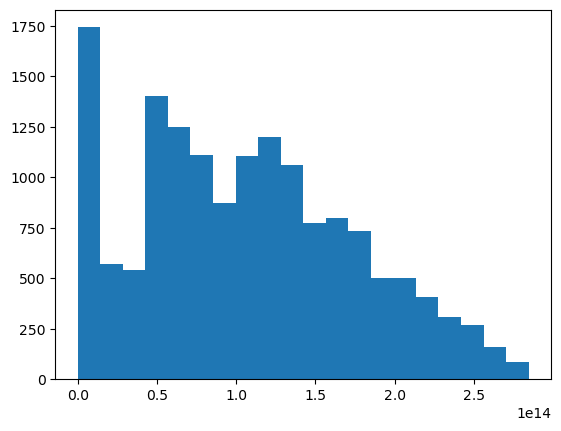

In [85]:
plt.hist(energy_flat, bins=20)

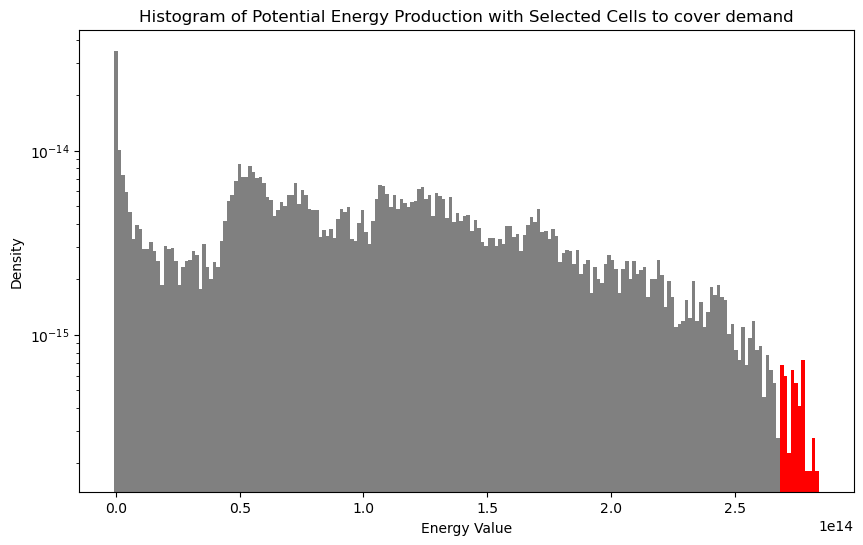

Total selected cells: 103
Total energy produced: 2.8358963072569116e+16


In [86]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_histogram_energy_supply(energy_flat, required_energy):
    # Example: Assuming 'data' is your xarray dataset and 'your_variable' is the energy variable
    # And 'required_energy' is the energy you want to achieve
    
    # 1. Flatten the energy variable into a 1D array
    values = energy_flat

    
    # 2. Sort values from highest to lowest (for selecting the highest producers)
    sorted_values = np.sort(values)[::-1]
    
    # 3. Calculate the cumulative energy and determine how many cells you need to reach the required_energy
    cumulative_energy = np.cumsum(sorted_values)
    
    # Find the index where cumulative energy exceeds or matches the required energy
    selected_cells_count = np.argmax(cumulative_energy >= required_energy) + 1  # +1 to include the cell that meets or exceeds the target
    
    # 4. Create histogram and calculate bin edges and bin counts
    hist_values, bin_edges = np.histogram(values, bins=200, density=True)
    
    # 5. Assign two colors: one for selected cells, another for non-selected cells
    # We will use a mask to mark the selected cells
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
    selected_bins = bin_centers >= sorted_values[selected_cells_count-1]  # Select bins based on the cumulative energy
    
    # 6. Create a color mapping for the bins: selected or not
    colors = ['red' if selected else 'gray' for selected in selected_bins]
    
    # 7. Plot the histogram with two colors
    plt.figure(figsize=(10, 6))
    for i in range(len(hist_values)):
        plt.bar(bin_edges[i], hist_values[i], width=np.diff(bin_edges)[i], color=colors[i])
    
    # Add titles and labels
    plt.title('Histogram of Potential Energy Production with Selected Cells to cover demand')
    plt.xlabel('Energy Value')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.show()
    
    # Output the number of cells selected and the total energy produced
    print(f"Total selected cells: {selected_cells_count}")
    print(f"Total energy produced: {cumulative_energy[selected_cells_count-1]}")

plot_histogram_energy_supply(energy_flat, europe_electricity_consumption.magnitude)